In [26]:
from pprint import pprint
%load_ext autoreload
%autoreload 2

import plots
import runner
import analysis
import processing
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Coupled Networks

Meng et al. setup for the 2 coupled network case:

* network with all-to-all coupling
* noisy-inputs to different neurons belonging to same or different network are uncorrelated
* IF neuron model
* input noise for a neuron is modeled as independent Poisson spike trains, mean rate is equal inside a network
* only inhibitory connections, gamma rhythm produced by ING mechanism
* local and global order parameter to measure synchrony

Observations
* with very weak noise: LFPs of different networks do not synchronize, they oscillate at different frequencies -> $r_{global}$ is small
* if noise increases at a certain point system jumps and global order parameter is significantly higher
* Reduction of noise leads now to increased desynchronization

Meng et al. main finding is that independent noise lead to synchronization across two networks

----

How can we replicate and extend with our current setup?

* two EI networks (X) showing activity in gamma frequency band
* gamma produced by PING
* input noise also as Poisson Group per neuron
* compute local and global order parameter for one run
* parameter exploration with noise strength
* collect results and compare local and global order parameters
* generate plots for specific configurations as visual proof

In [20]:
params = {
 "J_itoi": 0.0,
 "J_etoe": 0.,
 "J_etoi": 0.,
 "J_itoe": 0.,
 "ext_input_type": "poisson", # Independent spike trains generated by Poisson Point Process for each target neuron
 "poisson_strength": 1, # in mV, influence of a pre synaptic spike
 "poisson_rate": 30, # 50 Hz rate as in Meng et. al.
}

model = runner.run(modified_params=params, file_name="base")

Initializing net ...
initialization time: 0.21419978141784668s
------------------ running network!
runtime: 8.0


In [21]:
if 'model' not in locals() or model is None:
    model = analysis.load_model("base")

WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
 [py.warnings]
WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
 [py.warnings]
WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


Generate PSD plot ...


(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13891a0f0>)

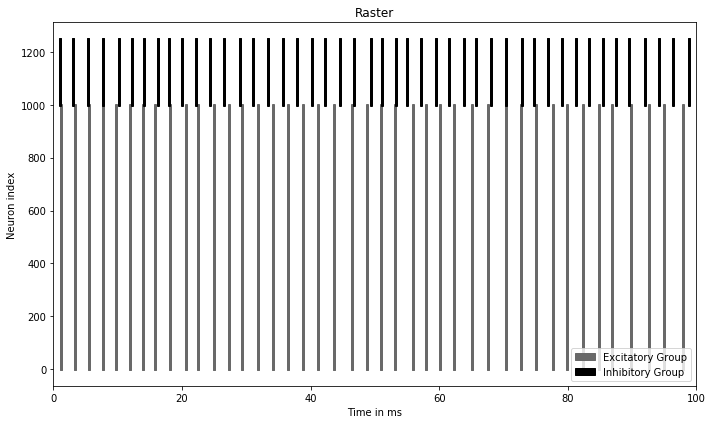

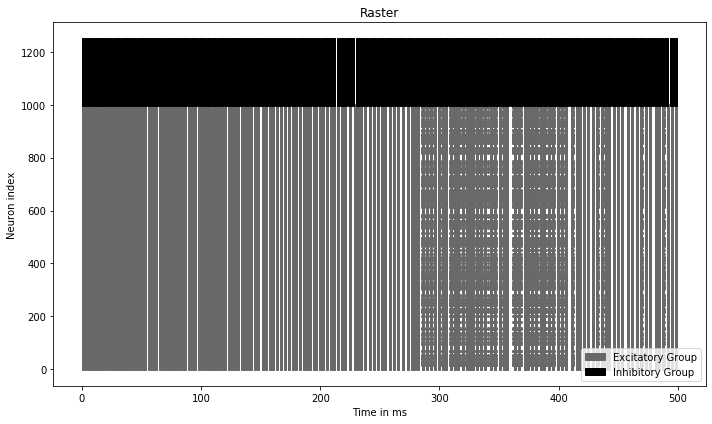

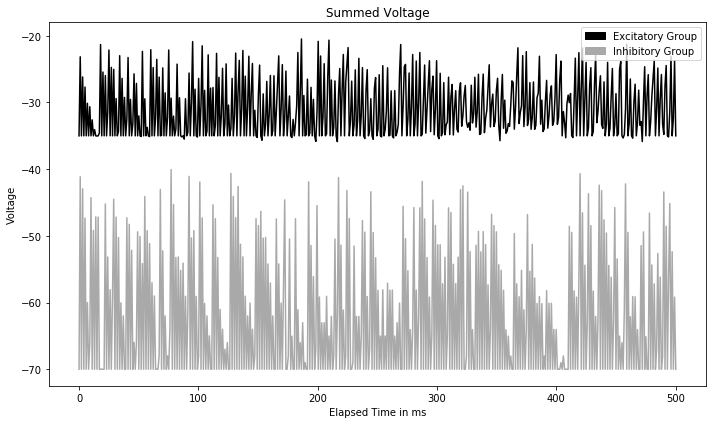

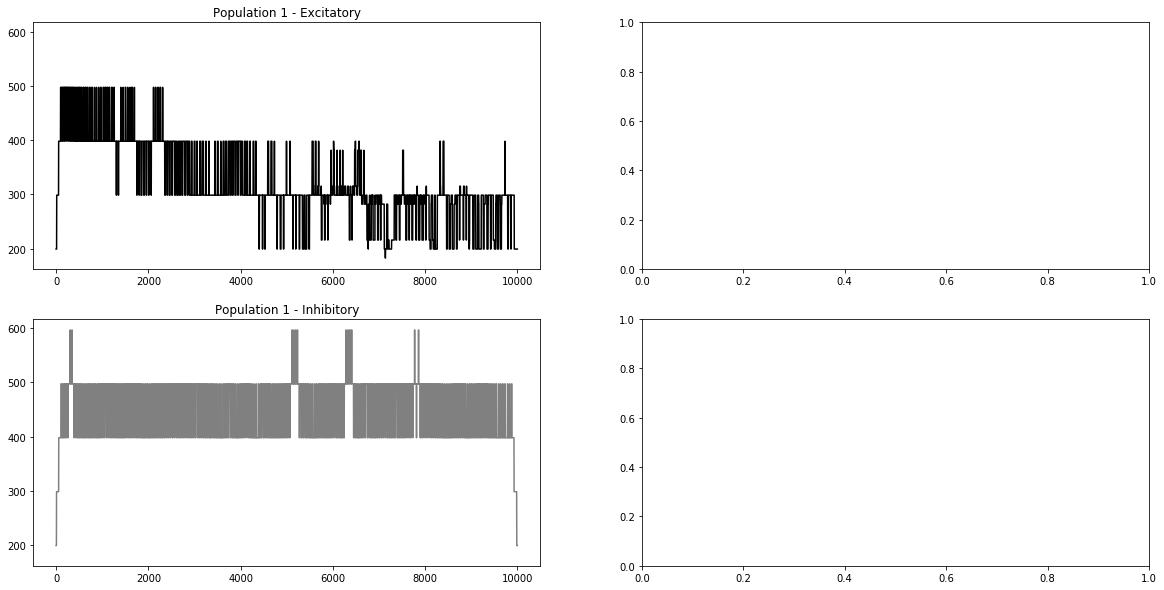

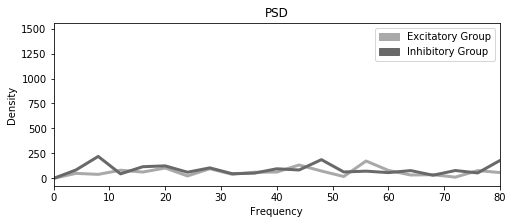

In [22]:
plots.raster(model=model, x_left=0, x_right=100)
plots.raster(model=model)
plots.lfp(model=model)
plots.population_rates(model)
plots.psd(model, title="PSD")

array([-2.93552891, -3.28720778, -3.19638029, -3.21211495, -3.24389021,
       -3.17326457, -3.28252895, -3.14385063, -3.26229733, -3.11779996])
[-168.19341741459667,
 -168.19307117808248,
 -168.19375866827625,
 -168.19307024705608,
 -168.1937460971219,
 -168.19385454432557,
 -168.19306343211,
 -168.19305418563692,
 -168.1934956688718,
 -168.1929535988397]
Local order of -3.143556475466891


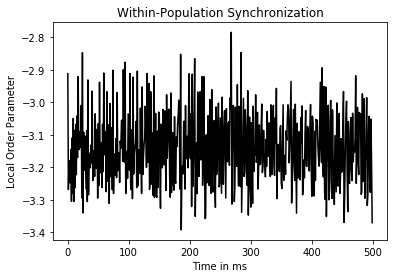

In [28]:
neurons_e = model['model_results']['net']['v_all_neurons_e']
neurons_i = model['model_results']['net']['v_all_neurons_i1']

phases = [processing.phase(neuron) for neuron in neurons_e]
phases.extend([processing.phase(neuron) for neuron in neurons_i])

pprint(phases[0][:10])
pprint([np.degrees(phase)[0] for phase in phases[:10]])

# average of each time step
avg_phase = np.average(phases, axis=0)

plt.title("Within-Population Synchronization")
plt.xlabel("Time in ms")
plt.ylabel("Local Order Parameter")
# plt.ylim(-2, 2)
plt.plot(avg_phase, c="black")

# TODO: we probably cannot simply take average of phase, have to convert it to complex representation and then average it?
print(f"Local order of {np.average(avg_phase)}")

PLV of excitatory group 0.0488331742361538


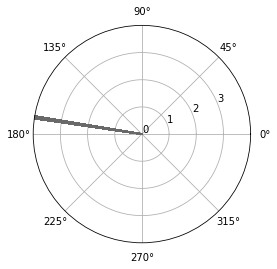

In [24]:
plv = processing.phase_locking_value(neurons_e)
print(f"PLV of excitatory group {plv}")

phases = [processing.phase(neuron) for neuron in neurons_e]

plt.axes(polar=True)
plt.ylim(0, 4)
plt.yticks(np.arange(0, 4 , 1.0))
for angle in phases:
    # TODO: calculate average across time for each neuron!

    # only angle matters, therefore we set constant radius
    plt.plot((0, angle[1]), (0, 4), c="dimgrey")
plt.show()